In [5]:
!pip install jiwer
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.2 MB/s eta 0:00:0

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

**Part 1 - Load Common Voice Data From Huggingface**

In [24]:
from datasets import load_dataset

cv_train = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="train", streaming=True)
cv_test = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test", streaming=True)

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [ ]:
# Preprocess the audio data

# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def preprocess_audio(audio, label):
    #return audio array
    audio = audio['array']
    #Resample audio
    audio = librosa.resample(audio, 48000, 16000)
    # Convert audio to float
    audio = tf.cast(audio, tf.float32)
    # Normalize audio
    audio /= tf.math.reduce_max(audio)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
# Store the first 1,000 records from the train split and 200 records from the test split in separate dictionaries
# We take this step b/c the common voice data is far too large to process on a single machine
train_data_dict = {}
test_data_dict = {}
train_count = 0
test_count = 0
for example in cv_train:
    if train_count >= 1000:  # Stop streaming after 10,000 records
        break
    # Store the relevant fields in a dictionary
    train_data_dict[example['path']] = {'audio': example['audio'], 'sentence': example['sentence'], 'up_votes': example['up_votes'], 'down_votes': example['down_votes']
                  , 'age': example['age'], 'gender': example['gender'], 'accent': example['accent']}
    train_count += 1
for example in cv_test:
    if test_count >= 200:  # Stop streaming after 1,000 records
        break
    # Store the relevant fields in a dictionary
    test_data_dict[example['path']] = {'audio': example['audio'], 'sentence': example['sentence'], 'up_votes': example['up_votes'], 'down_votes': example['down_votes']
                  , 'age': example['age'], 'gender': example['gender'], 'accent': example['accent']}
    test_count += 1

Reading metadata...: 948736it [01:09, 13734.95it/s]
Reading metadata...: 16354it [00:00, 21066.34it/s]


**Part 2 - Exploratory Data Analysis**

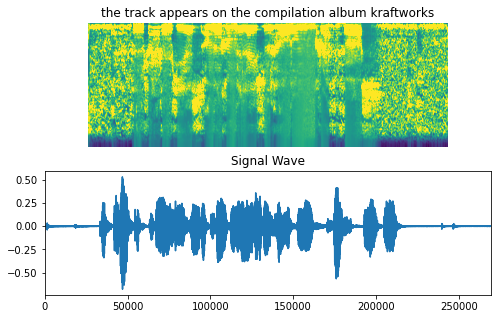

In [ ]:
#visualize spectrogram, display audio, show text label
for key, item in train_data_dict.items():
  item = item
  break
item

spectrogram, label = preprocess_audio(item["audio"], item["sentence"])
spectrogram[0]

fig = plt.figure(figsize=(8, 5))
spectrogram = spectrogram.numpy()
spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
# Spectrogram
label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
ax = plt.subplot(2, 1, 1)
ax.imshow(spectrogram, vmax=1)
ax.set_title(label)
ax.axis("off")
# Audio
audio = item['audio']['array']
ax = plt.subplot(2, 1, 2)
plt.plot(audio)
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
display.display(display.Audio(np.transpose(audio), rate=48000))
plt.show()

In [2]:
#load metadata from google drive
from google.colab import drive
drive.mount(r'/content/drive')

Mounted at /content/drive


In [3]:
# Load full train + test set for visualization

train_file_eda = '/content/drive/MyDrive/Machine Learning Final Project/data/cv-valid-train.csv'
test_file_eda = '/content/drive/MyDrive/Machine Learning Final Project/data/cv-valid-test.csv'
df_train_eda = pd.read_csv(train_file_eda)
df_test_eda = pd.read_csv(test_file_eda)

# Merge the train and test datasets into one dataframe
df_full_eda = pd.concat([df_train_eda, df_test_eda])

# Reset the index of the merged dataframe
df_full_eda.reset_index(drop=True, inplace=True)

# Print the number of samples in the merged dataframe
print(f"Number of samples in the merged dataframe: {len(df_full_eda)}")

Number of samples in the merged dataframe: 199771


In [ ]:
df_full_eda.sample(n=10, random_state=1)

,filename,text,up_votes,down_votes,age,gender,accent,duration
104518,cv-valid-train/sample-104518.mp3,the two men hurried back and found the cylinde...,2,1,NaN,NaN,NaN,NaN
46080,cv-valid-train/sample-046080.mp3,the shop folks were taking down their shutters...,2,0,fourties,male,england,NaN
123326,cv-valid-train/sample-123326.mp3,oh yes you do,1,0,NaN,NaN,NaN,NaN
193150,cv-valid-train/sample-193150.mp3,the shop was busy and the man asked the shephe...,2,0,fourties,male,australia,NaN
15343,cv-valid-train/sample-015343.mp3,he was excited and at the same time uneasy may...,1,0,twenties,male,NaN,NaN
1862,cv-valid-train/sample-001862.mp3,the shepherd said nothing,2,0,teens,female,us,NaN
169729,cv-valid-train/sample-169729.mp3,but then he remembered that he wasn't going to...,4,0,twenties,female,us,NaN
127927,cv-valid-train/sample-127927.mp3,from the railway station in the distance came ...,3,0,thirties,male,england,NaN
198189,cv-valid-test/sample-002413.mp3,it sort of makes a fellow lose faith in himself,1,0,NaN,NaN,NaN,NaN
126915,cv-valid-train/sample-126915.mp3,absolutely despicable that gingerbread men are...,3,0,NaN,NaN,NaN,NaN


In [7]:
#Set Plot themes

# Get the seaborn color palette
sns_palette = sns.color_palette("deep", n_colors=5)

# Convert the seaborn palette to a list of RGB colorcodes
plotly_colors = ["rgb({},{},{})".format(*rgb) for rgb in sns_palette]

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


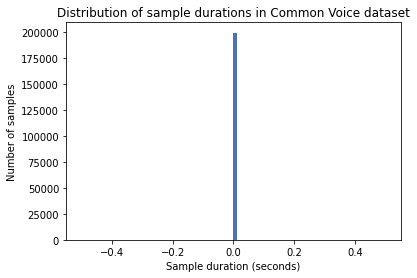

In [8]:
#Variable Distributions

# Create a histogram of sample durations

plt.style.use('seaborn-dark-palette')
current_palette = sns.color_palette('deep')
sns.set_palette(current_palette)
plt.hist(df_full_eda['duration'].notna(), bins=100)
plt.xlabel('Sample duration (seconds)')
plt.ylabel('Number of samples')
plt.title('Distribution of sample durations in Common Voice dataset')
plt.show()

In [10]:
df_full_eda['word_count'] = df_full_eda['text'].str.split().str.len()

# Create the histogram
fig = px.histogram(df_full_eda, x='word_count', nbins=100, title='Distribution of Word Counts', color_discrete_sequence=plotly_colors)
fig.update_xaxes(title='Word count')
fig.update_yaxes(title='File Count')
fig.update_layout(width=800, height=600)

fig.show()

In [11]:
# Create a bar chart of the average word count per language
# Calculate the word count for each text string in the 'text' column
df_full_eda['word_count'] = df_full_eda['text'].str.split().str.len()

# Create a bar chart of the average word count per language
mean_word_counts = df_full_eda.groupby('accent')['word_count'].mean().sort_values(ascending=False).reset_index()

fig = px.bar(mean_word_counts, x='accent', y='word_count', title='Average word count per language in Common Voice dataset', color_discrete_sequence=plotly_colors)
fig.update_xaxes(title='Language')
fig.update_yaxes(title='Average word count')
fig.update_layout(width=800, height=600)

fig.show()

In [14]:
# Get the number of samples per accent
accent_counts = df_full_eda['accent'].value_counts().reset_index()
accent_counts.columns = ['accent', 'count']

# Create the bar chart
fig = px.bar(accent_counts, x='accent', y='count', color='accent', title='Distribution of accents in Common Voice dataset', color_discrete_sequence=plotly_colors)
fig.update_xaxes(title='Accent')
fig.update_yaxes(title='File Count')
fig.update_layout(showlegend=False)
fig.update_layout(width=800, height=600)

fig.show()

In [15]:
# Create a bar chart of speaker ages
age_counts = df_full_eda['age'].value_counts()
fig = px.bar(x=age_counts.index, y=age_counts.values, color_discrete_sequence=plotly_colors)
fig.update_xaxes(title='Age')
fig.update_yaxes(title='File Count')
fig.update_layout(title='Distribution of Ages')
fig.update_layout(width=800, height=600)

fig.show()

In [17]:
# Create a bar chart of speaker gender
age_counts = df_full_eda['gender'].value_counts()
fig = px.bar(x=age_counts.index, y=age_counts.values, color_discrete_sequence=plotly_colors)
fig.update_xaxes(title='gender')
fig.update_yaxes(title='File Count')
fig.update_layout(title='Distribution of Gender')
fig.update_layout(width=800, height=600)

fig.show()

In [19]:
# Get the seaborn color palette
sns_palette = sns.color_palette("deep", n_colors=5)

# Convert the seaborn palette to a list of RGB colorcodes
plotly_colors = ["rgb({},{},{})".format(*rgb) for rgb in sns_palette]


age_count=df_full_eda.groupby(['age','gender']).agg({'filename':'count'}).reset_index()
fig = px.bar(age_count, x="age", y="filename", color="gender", title="Distribution of Age by Gender",text_auto=True, color_discrete_sequence=plotly_colors).update_xaxes(categoryorder="total descending")
fig.update_yaxes(title="File Count")
fig.update_xaxes(title="Age")
fig.update_layout(width=800, height=600)

fig.show()

In [20]:
# Calculate the number of up_votes and down_votes by accent
votes_by_accent = df_full_eda.groupby('accent')['up_votes', 'down_votes'].sum()

# Sort the data by the largest number of up_votes
votes_by_accent = votes_by_accent.sort_values('up_votes', ascending=False)

# Split the up_votes and down_votes into positive and negative values
up_votes = votes_by_accent['up_votes']
down_votes = -1 * votes_by_accent['down_votes']

# Create a stacked bar chart of the number of up_votes and down_votes by accent
fig = go.Figure(data=[
    go.Bar(x=up_votes.index, y=up_votes, name='up_votes', marker_color=plotly_colors[0]),
    go.Bar(x=down_votes.index, y=down_votes, name='down_votes', marker_color=plotly_colors[1])
])

fig.update_xaxes(title='Accent', tickangle=90)
fig.update_yaxes(title='Number of votes')
fig.update_layout(title='Number of up_votes and down_votes by accent in Common Voice dataset', barmode='relative', colorway=plotly_colors)
fig.update_layout(width=800, height=600)

fig.show()

<ipython-input-20-eaa627bb3217>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



**Part 3 - Model 1: Speech Recognition Using CTC**

In [ ]:
# Create a TensorFlow Dataset from the Common Voice data
batch_size = 32

train_ds = tf.data.Dataset.from_generator(
    lambda: ((preprocess_audio(item["audio"], item["sentence"])) for key, item in train_data_dict.items()),
    output_types=(tf.float32, tf.int32),
    output_shapes=((None, 193), (None,)))
train_ds = train_ds.padded_batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    lambda: ((preprocess_audio(item["audio"], item["sentence"])) for key, item in test_data_dict.items()),
    output_types=(tf.float32, tf.int32),
    output_shapes=((None, 193), (None,)))
test_ds = test_ds.padded_batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [ ]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs.
epochs = 10
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(test_ds)
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[validation_callback],
)


Epoch 1/10
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : i have never in life hit a tennis ball
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : she was also appointed the eleanor easley distinguished professor of medicine
Prediction: 
----------------------------------------------------------------------------------------------------
32/32 [==============================] - 462s 14s/step - loss: 285.9003 - val_loss: 186.2838
Epoch 2/10
1/1 [==============================] - 0s 209ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
--------------------------------------------------------------

In [ ]:
# Check results on more validation samples
predictions = []
targets = []
for batch in test_ds:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 217ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : shell be all right
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : alston commented that he felt the cartoonist might have had some racial intent
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the current representative for the district is democrat karin power of milwaukie
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the genus name was given in honour of queen victoria of the united kingdom
Prediction: 
----------------------------------------------------------------

**Part 4 - Model 2: Wave2Vec**

In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.2 MB/s eta 0:00:00


In [22]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

# Load the pre-trained processor and feature extractor
# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import librosa
import warnings
warnings.filterwarnings("ignore")

i = 0
print("-" * 100)
for item in cv_train:
  item_val = item
  # Resample the audio signal to 16 kHz
  resampled_audio = librosa.resample(item_val["audio"]["array"], orig_sr=item_val["audio"]["sampling_rate"], target_sr=16000)

  # tokenize
  input_values = processor(resampled_audio, return_tensors="pt", sampling_rate = 16000, padding="longest").input_values  # Batch size 1
  
  # retrieve logits
  logits = model(input_values).logits
  
  # take argmax and decode
  predicted_ids = torch.argmax(logits, dim=-1)
  transcription = processor.batch_decode(predicted_ids)
  print(f"Target    : {item_val['sentence'].lower()}")
  print(f"Prediction: {transcription[0].lower()}")
  print("-" * 100)

  if i > 4:
    break
  i+= 1

----------------------------------------------------------------------------------------------------


Reading metadata...: 948736it [00:29, 31999.28it/s]


Target    : the track appears on the compilation album "kraftworks".
Prediction: the trick appears on the compillation album craftwerks
----------------------------------------------------------------------------------------------------
Target    : the massachusetts division of fisheries and wildlife has stocked the jones river with trout.
Prediction: the massachusetts division of fisheries and wide life has stuck the jones river with trout
----------------------------------------------------------------------------------------------------
Target    : the most common playing format for poker tournaments is the "freezeout" format.
Prediction: the most common playing forment for poker tournaments is the freeze out form it
----------------------------------------------------------------------------------------------------
Target    : rafting became less important after the construction of the murg valley railway.
Prediction: rafting became less important after the construction of the murk

In [ ]:
#validate word2vec
import re

def map_to_pred(dict):

  pred_list = []
  actual_list = []
  i=0
  for item in dict:
    item_val = item
    # Resample the audio signal to 16 kHz
    resampled_audio = librosa.resample(item_val["audio"]["array"], orig_sr=item_val["audio"]["sampling_rate"], target_sr=16000)
    input_values = processor(resampled_audio, return_tensors="pt", sampling_rate = 16000, padding="longest").input_values
    # retrieve logits
    logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    pred_list.append(transcription[0].lower())
    actual_list.append(item_val['sentence'].lower())
    i+=1
    if i > 1000:
      break

  return pred_list, actual_list

pred_list, actual_list = map_to_pred(cv_test)

In [38]:
for i in range(0,len(actual_list)-1):
  if actual_list[i] == '' or pred_list[i] == '':
    del actual_list[i]
    del pred_list[i]

wer_score = wer(pred_list, actual_list)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4910
----------------------------------------------------------------------------------------------------
